In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import os

project_dir = os.path.dirname(os.getcwd())
sys.path.append(project_dir) # append project directory to path for import
os.chdir(project_dir) # change current working directory to project directory

/eos/home-i01/a/astadnit/SWAN_projects/online-offline-jec


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
#from matplotlib import colormaps

import awkward as ak
import uproot
import hist
import mplhep as hep
import coffea
from coffea import util as cutil
from coffea.lumi_tools import LumiData

import string
import warnings
from functools import partial
import inspect

import itertools
from scipy import optimize
from scipy import stats

from util import *
from analysis.analysis_util import *
from analysis.plot import *

In [7]:
# configure plot style
hep.style.use("CMS")

data_hep_args={"label":"private", "loc":0, "data":True, "com":13.6}
mc_hep_args={"label":"private", "loc":0, "data":False, "com":13.6}

# global plot parameters
eta_bin_coarse = [0, 1.3, 2.5, 3.0, 5.0]

## Load Coffea output

In [10]:
#output_dir = "/ssd-home/pinkaew/research/online-offline-jec/coffea_output"
#output_dir = "/work/pinkaew/research/online-offline-jec/coffea_output"
#output_filename = "runD_AK4Puppi_HLT_notrigger_notagprobe.coffea"
#output_filename = "mc_AK4Puppi_HLT_notrigger_notagprobe_all.coffea"
#output_filename = "mc_AK4Puppi_HLT_notrigger_notagprobe_weighted_response.coffea"
#output_filename = "JetMET_2022D_AK4Puppi_HLT_notrigger_notagprobe_noMET_comp.coffea"
#output_filename = "JetMET_2022D_AK4Puppi_HLT_notrigger_notagprobe_comp.coffea"
#output_filename = "JetMET_2022E_AK4Puppi_HLT_notrigger_notagprobe_noMET_comp.coffea"
#output_filename = "JetMET_2022E_AK4Puppi_HLT_notrigger_notagprobe_comp.coffea"
#output_filename = "runE_AK4Puppi_HLT_notrigger_notagprobe_lxplus.coffea"
#out = coffea.util.load(os.path.join(output_dir, output_filename))
output_dir = "coffea_output"
output_filename = 'QCD_2022_AK4PUPPI_AK4Scouting_notrigger_tagprobe20_tpbalance10.coffea'
#out = coffea.util.load(os.path.join(output_dir, output_filename))
out = coffea.util.load(os.path.join(output_dir, os.path.splitext(output_filename)[0], output_filename))

In [11]:
print(out.keys())
print_dict_json(out["arguments"], "arguments")
print_dict_json(out["configurations"], "configurations")

dict_keys(['tp_pt_balance', 'cutflow', 'arguments', 'configurations', 'start_timestamp', 'process_time'])
arguments
{
    "config_file": "configs/QCD_2022_AK4PUPPI_AK4Scouting_notrigger_tagprobe20_tpbalance10.cfg"
}
configurations
{
    "IO": {
        "input_paths": "fileset/QCD_2022_Scouting_fileset_redirector.json",
        "dataset_names": "None",
        "check_bad_files": "False",
        "max_files": "10",
        "xrootd_redirector": "None",
        "base_output_dir": "coffea_output",
        "output_dir": "coffea_output/QCD_2022_AK4PUPPI_AK4Scouting_notrigger_tagprobe20_tpbalance10",
        "output_file": "coffea_output/QCD_2022_AK4PUPPI_AK4Scouting_notrigger_tagprobe20_tpbalance10/QCD_2022_AK4PUPPI_AK4Scouting_notrigger_tagprobe20_tpbalance10.coffea"
    },
    "Processor": {
        "off_jet_name": "Jet",
        "off_jet_label": "AK4PUPPI",
        "on_jet_name": "ScoutingJet",
        "on_jet_label": "AK4Scouting",
        "lumi_json_path": "None",
        "lumi_csv_path"

## Luminosity

In [ ]:
dataset = out["configurations"]["IO"]["dataset_names"]
#dataset = "JetMET"

In [ ]:
from coffea.lumi_tools import LumiData
data_taking_era = "2022E"

lumidata = LumiData("corrections/lumidata/lumi{}.csv".format(data_taking_era))
out["processed_lumi"][dataset]["lumi_list"].unique() # apply unique
out["processed_lumi"][dataset]["lumi"] = lumidata.get_lumi(out["processed_lumi"][dataset]["lumi_list"])

In [ ]:
# pick hep_args
is_data = eval(out["configurations"]["Processor"]["is_data"])
if is_data:
    print("luminosity: {:.3f}".format(out["processed_lumi"][dataset]["lumi"]))
    data_hep_args["lumi"] = "{:.3f}".format(out["processed_lumi"][dataset]["lumi"])
    
data_hep_args["year"] = data_taking_era
hep_args = data_hep_args if is_data else mc_hep_args

In [ ]:
hep_args

## Cutflow

## 2D Correlation

In [ ]:
#from sklearn.decomposition import PCA

# re-implement methods from TH2
def get_stats(h):
    assert len(h.axes.name) == 2, "Histogram must be two dimensional"
    w = h.counts()
    x = np.expand_dims(h.axes[0].centers, axis=1)
    y = np.expand_dims(h.axes[1].centers, axis=0)
    sumw = np.sum(w)
    sumw2 = None
    sumwx = np.sum(w*x)
    sumwx2 = np.sum(w*(x*x))
    sumwy = np.sum(w*y)
    sumwy2 = np.sum(w*(y*y))
    sumwxy = np.sum((w*x)*y)
    
    return {"sumw": sumw, "sumw2": None, 
            "sumwx": sumwx, "sumwx2":sumwx2, 
            "sumwy": sumwy, "sumwy2": sumwy2, 
            "sumwxy": sumwxy}

def get_covariance(h):
    assert len(h.axes.name) == 2, "Histogram must be two dimensional"
    stats = get_stats(h)
    return stats["sumwxy"]/stats["sumw"] - stats["sumwx"]/stats["sumw"]*stats["sumwy"]/stats["sumw"]

def get_correlation_factor(h):
    assert len(h.axes.name) == 2, "Histogram must be two dimensional"
    stats = get_stats(h)
    stdevx = np.sqrt(stats["sumwx2"]/stats["sumw"] - (stats["sumwx"]/stats["sumw"])**2)
    stdevy = np.sqrt(stats["sumwy2"]/stats["sumw"] - (stats["sumwy"]/stats["sumw"])**2)
    cov = stats["sumwxy"]/stats["sumw"] - stats["sumwx"]/stats["sumw"]*stats["sumwy"]/stats["sumw"]
    return cov/stdevx/stdevy

def repeat_value_from_freq(values, freqs):
    return list(itertools.chain.from_iterable([itertools.repeat(elem, n) for elem, n in zip(values, freqs)]))

def build_points_from_histogram(h):
    assert len(h.axes.name) == 2, "Histogram must be two dimensional"
    w = h.counts()
    x = h.axes[0].centers
    y = h.axes[1].centers
    values = itertools.product(x, y)
    points = np.array(repeat_value_from_freq(values, w.reshape(-1)))
    return points

def compute_correlation(h):
    points = build_points_from_histogram(h)
    return stats.pearsonr(points[:, 0], points[:, 1])[0]

def compute_pca(h):
    points = build_points_from_histogram(h)
    return PCA(n_components=2).fit(points)

# example for converting to root
# root_file = uproot.recreate("test_uproot_file.root")
# root_file["hist"] = h_test.to_numpy()

# histFile = ROOT.TFile.Open("test_uproot_file.root")
# dataHisto = histFile.Get("hist")

# dataHisto.GetCorrelationFactor()

In [ ]:
def plot_online_offline_pt(out, dataset="QCD", correction_level="Raw", 
                           eta_range=None, phi_range=None,
                           trigger_value=None, trigger_values=None,
                           xscale=None, yscale=None, xlim=None, ylim=None,
                           legend_title=None, 
                           hep_args=None, 
                           filename=None, dpi=100):
    fig, ax = plt.subplots()
    cmap = colormaps['rainbow']
    #cmap.set_bad("k")
    cmap.set_under("w")
    
    off_jet_label = out["configurations"]["Processor"]["off_jet_label"]
    on_jet_label = out["configurations"]["Processor"]["on_jet_label"]
    correction_level = format_correction_level(correction_level) # TODO: need to fix this
    
    
    h = preprocess_histogram(out["comparison"], dataset=dataset,
                             correction_level=correction_level,
                             jet_type=off_jet_label, # + " (Matched Gen)", 
                             eta_range=eta_range, phi_range=phi_range)
    h = h.project("off_jet_pt", "on_jet_pt")
#     h_np = h.values() # convert to np
#     h_np_norm = np.where(h_np < 1e7, h_np, 0)
#     h_norm = hist.Hist(*h.axes, storage=hist.storage.Double())
#     h.view()[:] = h_np_norm # convert back to hist
    h.plot2d(ax=ax, cmap=cmap, alpha=1, norm=colors.LogNorm())
    
    
    # compute correlation
    corr = get_correlation_factor(h)
    
    # compute pca and plot first principal component (PC1)
#     pca = compute_pca(h)
#     pca_comp0 = pca.components_[0]
#     pca_var0 = pca.explained_variance_[0]
#     pca_scaled_comp0 = pca_comp0 * pca_var0  # scale component by its variance explanation power
#     ax.plot([0, pca_scaled_comp0[0]], [0, pca_scaled_comp0[1]], 
#              label="PC1", linewidth=1.5, color="black")
    
    # plot y = x
    ax.axline([1, 1], slope=1, color="k", linestyle="dashed")
    ax.text(1e4, 8e3, "y=x", rotation=45, fontsize=20)
    
    # plot x=trigger_values and y=trigger_values
    if trigger_values:
        for value in trigger_values:
            ax.axhline(y=value, color="k", linestyle="dotted", alpha=0.3)
            ax.axvline(x=value, color="k", linestyle="dotted", alpha=0.3)
    
    # plot x=trigger_values and y=trigger_values (highlight)
    if trigger_value:
        ax.axhline(y=trigger_value, color="k", linestyle="dotted", alpha=1)
        ax.axvline(x=trigger_value, color="k", linestyle="dotted", alpha=1)
        
    legend_title_list = [dataset]
    if eta_range:
        legend_title_list.append(format_eta_range_text(eta_range[0], eta_range[1], 
                                                       jet_name=off_jet_label, omit_zero=True))
    legend_title_list.append("corr: {:.5f}".format(corr))
    if legend_title:
        legend_title = "\n".join([legend_title] + legend_title_list)
    else:
        legend_title = "\n".join(legend_title_list)
        
    # TODO: need to move to better place...
    off_correction_level, on_correction_level = extract_correction_level(correction_level)
    off_jet_pt_axis_label = "\ ".join([off_jet_label, "p_T", "({})".format(off_correction_level)])
    on_jet_pt_axis_label = "\ ".join([on_jet_label, "p_T", "({})".format(on_correction_level)])
    ax.set_xlabel(r"${}$".format(off_jet_pt_axis_label))
    ax.set_ylabel(r"${}$".format(on_jet_pt_axis_label))
    ax.set_xlim(1, 10)
    ax.set_xscale("log")
    
    #return
    # format and save plot
    format_plot(fig, ax, xscale=xscale, yscale=yscale, xlim=xlim, ylim=ylim,
                legend_title=legend_title, legend_args={"title_fontsize":20, "fontsize": 20},
                hep_args=hep_args,
                filename=filename, dpi=dpi)

In [ ]:
plot_online_offline_pt(out, dataset=dataset, correction_level= "Original", #"Original", #"off=Raw:on=Raw",
                       legend_title= "Notitled", #"pvmatched\nw/o T&P, w/ METfilters",
                       eta_range=(0, 1.3, True),
                       xscale="log", yscale="log", xlim=(1, 6e4), ylim=(1, 6e4), 
                       hep_args=hep_args)

In [ ]:
def plot_multiple_eta_bin(func, eta_bin_plot, func_args, mirror=True):
    for eta_plot_idx in range(len(eta_bin_plot)-1):
        eta_low = eta_bin_plot[eta_plot_idx]
        eta_high = eta_bin_plot[eta_plot_idx+1]
        func(**func_args, eta_range=(eta_low, eta_high, mirror))

In [ ]:
func_args = {"out": out, 
             "dataset": dataset, "correction_level": "Original", #"Original", #"off=Raw:on=Raw",
             "legend_title":"w/o METFilters",
             "xscale":"linear", "yscale":"linear", "xlim":(1, 1e4), "ylim":(1, 1e4), 
             "hep_args":hep_args}

In [ ]:
out["comparison"]

In [ ]:
plot_multiple_eta_bin(plot_online_offline_pt, eta_bin_plot=eta_bin_coarse, func_args=func_args, mirror=True)

## Fit pt response in each pt-eta bin

In [ ]:
def norm(x, A, mu, sigma):
    return A * stats.norm.pdf(x, mu, sigma)

def gamma(x, A, a, loc, scale):
    return A * stats.gamma.pdf(x, a, loc, scale)

def lognormal(x, A, mu, sigma, scale):
    return A * stats.lognorm.pdf(x, sigma, mu, scale)

def gumbel_r(x, A, loc, scale):
    return A * stats.gumbel_r.pdf(x, loc, scale)

def nct(x, A, df, nc, loc, scale):
    return A * stats.nct.pdf(x, df, nc, loc, scale)

In [ ]:
def fit_response(out, dataset="QCD", correction_level="Original", jet_type="PUPPI",
                 phi_range=None, # if range None, will integrate all
                 plot=False,
                 xscale="linear", yscale="linear", xlim=None, ylim=None,
                 legend_title=None, hep_args=None, filename=None, dpi=100):
    
    correction_level = format_correction_level(correction_level)
    h = preprocess_histogram(out["pt_response"], dataset=dataset, correction_level=correction_level, \
                        jet_type=jet_type, phi_range=phi_range)
    h = h.project("jet_pt", "jet_eta", "pt_response")
    
    h_stats = compute_stats(h)
    h_stats["fit_mean"] = np.nan * np.ones_like(h_stats["mean"])
    h_stats["fit_stdev"] = np.nan * np.ones_like(h_stats["stdev"])
    h_stats["fit_var"] = np.nan * np.ones_like(h_stats["var"])
    h_stats["fit_mean_error"] = np.nan * np.ones_like(h_stats["mean_error"])
    
    #return h_stats
    
    if plot:
        x_plot = np.linspace(h.axes[-1].edges[0], h.axes[-1].edges[-1], 500)
    
    for pt_bin_idx in range(len(h.axes[0])):
        pt_range_text = format_pt_range_text(*h.axes[0][pt_bin_idx], jet_name=jet_type, omit_zero=False)
        for eta_bin_idx in range(len(h.axes[1])):
            eta_range_text = format_eta_range_text(*h.axes[1][eta_bin_idx], jet_name=jet_type, \
                                                   absolute=False, omit_zero=False)
            
            h_resp = h[pt_bin_idx, eta_bin_idx, :]
            xdata = h_stats["centers"]
            ydata = h_stats["freqs"][pt_bin_idx, eta_bin_idx]
            yerr = np.sqrt(h_resp.variances())
            mask = (yerr != 0.0)
            xdata = xdata[mask]
            ydata = ydata[mask]
            yerr = yerr[mask]
            total = np.sum(ydata)
            num_nonzero_bins = np.sum(ydata > 0)
            
            if (num_nonzero_bins < 2) or (total < 50):
                continue
            #print(pt_bin_idx, eta_bin_idx, num_nonzero_bins, total) 
            try:
                # need to update this
                # inspired from hist.plot._fit_callable_to_hist
                #p0 = [10, 1, 1]
                p0 = [total, h_stats["mean"][pt_bin_idx, eta_bin_idx], h_stats["stdev"][pt_bin_idx, eta_bin_idx]]
                popt, pcov = optimize.curve_fit(norm, xdata, ydata, sigma=yerr, absolute_sigma=True, 
                                                p0=p0, maxfev=1000)

                _, fit_mean, fit_stdev = popt
                fit_mean_error = np.sqrt(pcov[1, 1])
            
                # populate stats dict
                h_stats["fit_mean"][pt_bin_idx, eta_bin_idx] = fit_mean
                h_stats["fit_stdev"][pt_bin_idx, eta_bin_idx] = fit_stdev
                h_stats["fit_var"][pt_bin_idx, eta_bin_idx] = fit_stdev ** 2
                h_stats["fit_mean_error"][pt_bin_idx, eta_bin_idx] = fit_mean_error
            except:
                #print(pt_bin_idx, eta_bin_idx, num_nonzero_bins, total)
                pass
            
            if plot:
                if not (pt_bin_idx == 28 and eta_bin_idx == 69):
                    continue
                
                fig, ax = plt.subplots()
                h_resp.plot(ax=ax) # plot histogram

                y_plot = norm(x_plot, *popt) # plot gaussian fit

                # for log y scale, plot only y > 1
                if yscale == "log":
                    ax.plot(x_plot[y_plot>=1], y_plot[y_plot>1])
                else:
                    ax.plot(x_plot, y_plot)
                    
                # add y axis label
                ax.set_ylabel("Events")

                # format legend
                legend_title = "" if not legend_title else legend_title + "\n"
                legend_title += "{}\n{}\n\n".format(pt_range_text, eta_range_text)
                legend_title += "count: {}\n".format(total)
                legend_title += "mean: {:.3f}\nstdev: {:.3f}\nmean_err: {:.3f}\n"\
                                .format(h_stats["mean"][pt_bin_idx, eta_bin_idx], 
                                        h_stats["stdev"][pt_bin_idx, eta_bin_idx], 
                                        h_stats["mean_error"][pt_bin_idx, eta_bin_idx])
                legend_title += "median: {:.3f}\nmedian_err: {:.3f}\n"\
                                .format(h_stats["median"][pt_bin_idx, eta_bin_idx],
                                        h_stats["median_error"][pt_bin_idx, eta_bin_idx])
                legend_title += "fit_mean: {:.3f}\nfit_stdev: {:.3f}\nfit_mean_err: {:.3f}"\
                                .format(fit_mean, fit_stdev, fit_mean_error)

                # TODO: write filename formatting for saving, use only None for now
                format_plot(fig, ax, xscale=xscale, yscale=yscale, xlim=xlim, ylim=ylim, 
                            legend_title=legend_title, legend_args={"title_fontsize":20},
                            hep_args=hep_args,
                            filename=filename, dpi=dpi)
            
    return h_stats

In [ ]:
out_fit_stats = fit_response(out, dataset="QCD", 
                             correction_level="Original", 
                             jet_type="AK4PUPPI",
                             xscale="linear", yscale="linear", 
                             legend_title="Original JEC", hep_args=mc_hep_args,
                             plot=True,
                             filename=None
                            )

In [ ]:
def plot_response_stat(pt_bins, eta_bins, response_stat,
                       jet_label="jet", 
                       xscale="linear", yscale="linear", xlim=None, ylim=None,
                       legend_title=None, hep_args=None, filename=None, dpi=100):
    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = cm.seismic_r
    cmap.set_bad(color='gray', alpha=0.2)

    hep.hist2dplot(response_stat, pt_bins, eta_bins, ax=ax, cmap=cmap, norm=colors.CenteredNorm(vcenter=1.0))
    
    # plot pt=40 GeV
    ax.axvline(x=40, color="k", linestyle="dotted")
    
    # plot eta range in eta_bin_plot
    for eta in eta_bins:
        ax.axhline(y=eta, color="k", linestyle="dotted")
        if eta !=0:
            ax.axhline(y=-eta, color="k", linestyle="dotted")
    
    ax.set_xlabel(r"$p_T^{%s}$"%(jet_label))
    ax.set_ylabel(r"$\eta^{%s}$"%(jet_label))
    
    format_plot(fig, ax, xscale=xscale, yscale=yscale, xlim=xlim, ylim=ylim, 
                legend_title=legend_title, legend_args={"title_fontsize":20},
                hep_args=hep_args,
                filename=filename, dpi=dpi)

In [ ]:
pt_bins = out["pt_response"].axes["jet_pt"].edges
eta_bins = out["pt_response"].axes["jet_eta"].edges

In [ ]:
plot_response_stat(pt_bins, eta_bins, out_fit_stats["fit_mean"],
                   jet_label="PUPPI",
                   xscale="log",
                   legend_title="Mean", hep_args=data_hep_args)

In [ ]:
fig, ax = plt.subplots()
pt_bin_centers = out["pt_response"].axes["jet_pt"].centers
plot_stats = ["mean", "median", "fit_mean"]
fmts = "os^"
for i, stat in enumerate(plot_stats):
    stat_err = stat + "_error"
    ax.errorbar(pt_bin_centers, out_fit_stats[stat][:, 3], yerr=out_fit_stats[stat_err][:, 3], 
                fmt=fmts[i], label=stat, alpha=0.5)
ax.axhline(y=1.0, linestyle="dotted", color="k")
ax.legend()
ax.set_xscale("log")
ax.set_ylim(-5, 6)
ax.legend(title=r"$0 < \eta$ < 1.3", loc=3)
ax.set_xlabel(r"AK4PUPPI $p_T$")
correction_level = format_correction_level("Original")
off_jet_label = "AK4PUPPI"
on_jet_label = "AK4HLT"
jet_type = "AK4PUPPI"
off_correction_level, on_correction_level = extract_correction_level(correction_level)
off_jet_pt_axis_label = "\ ".join([off_jet_label, "p_T", "({})".format(off_correction_level)])
on_jet_pt_axis_label = "\ ".join([on_jet_label, "p_T", "({})".format(on_correction_level)])
if jet_type.startswith(off_jet_label):
    jet_type_correction_level = off_correction_level
else:
    jet_type_correction_level = on_correction_level
jet_type_pt_axis_label = "\ ".join([*jet_type.split("_"), "p_T", "({})".format(jet_type_correction_level)])
ax.set_xlabel(r"${}$".format(jet_type_pt_axis_label))
ax.set_ylabel(r"$R = \frac{%s}{%s}$"%(str(on_jet_pt_axis_label), str(off_jet_pt_axis_label)))
ax.grid()
hep.cms.label(**mc_hep_args)

In [ ]:
fig, ax = plt.subplots()
#out["pt_response"]["QCD", "off=Original:on=Original", "AK4PUPPI", 29, 3, sum, :].plot1d(ax=ax)
out["pt_response"]["QCD", "off=Original:on=Original", "AK4PUPPI", -4, 3, sum, :].plot1d(ax=ax)

In [ ]:
out_fit_stats["mean_error"][:, 3]

In [ ]:
def plot_tp_response(out, dataset="QCD",
                     jet_type=None,
                     eta_range=None, phi_range=None, # if range None, will integrate all
                     normalize_pt=False, plot_what={"2d", "profile"},
                     fig = None, ax = None,
                     xscale=None, yscale=None, xlim=None, ylim=None,
                     legend_title=None, hep_args=None, filename=None):
    if fig == None or ax == None:
        fig, ax = plt.subplots()
    size = fig.get_size_inches()
    fig.set_size_inches((size[0]*1.5, size[1]))
    
    cmap = cm.get_cmap('rainbow')
    cmap.set_under('w')
    
    on_jet_label = out["configurations"]["Processor"]["on_jet_label"]
    off_jet_label = out["configurations"]["Processor"]["off_jet_label"]
    if not jet_type:
        jet_type = off_jet_label
        
    h = preprocess_histogram(out["tp_response"], dataset=dataset, \
                            jet_type=jet_type, eta_range=eta_range, phi_range=phi_range)
    
    h = (h.project("jet_pt", "tp_response"))[0j:, :]
    
    if plot_what == None:
        plot_what = {"2d", "profile"}
    
    if "2d" in plot_what:
        if normalize_pt:
            h_np = h.values() # convert to np
            h_np_norm = h_np / np.sum(h_np, axis=1, keepdims=True)
            h_norm = hist.Hist(*h.axes, storage=hist.storage.Double())
            h_norm.view()[:] = h_np_norm # convert back to hist
            h_norm.plot2d(ax=ax, cmap=cmap, alpha=1, norm=colors.LogNorm())

        else:
            h.plot2d(ax=ax, cmap=cmap, alpha=1, norm=colors.LogNorm())
    
    # compute profile and plot profile
    if "profile" in plot_what:
        hp = h.profile("tp_response")
        hp.plot(color="k", linewidth=1.5)
        ax.plot(hp.axes[0].centers, hp.to_numpy()[0], color="k", linestyle="", marker="^", markersize=3)
    
    # plot pt_response = 1.0 line
    ax.axhline(1, linestyle="dashed", color="k", alpha=0.5)
    
    ax.set_xlabel(r"$p_T^{%s}$"%off_jet_label)
    ax.set_ylabel(r"$p_T^{%s} / p_T^{%s}$"%(on_jet_label, off_jet_label))
    
    # TODO: need to move to better place...
    #off_correction_level, on_correction_level = extract_correction_level(correction_level)
    #off_jet_pt_axis_label = "\ ".join([off_jet_label, "p_T", "({})".format(off_correction_level)])
    #on_jet_pt_axis_label = "\ ".join([on_jet_label, "p_T", "({})".format(on_correction_level)])
    #if jet_type.startswith(off_jet_label):
    #    jet_type_correction_level = off_correction_level
    #else:
    #    jet_type_correction_level = on_correction_level
    #jet_type_pt_axis_label = "\ ".join([*jet_type.split("_"), "p_T", "({})".format(jet_type_correction_level)])
    #ax.set_xlabel(r"${}$".format(jet_type_pt_axis_label))
    #ax.set_ylabel(r"$R = \frac{%s}{%s}$"%(str(on_jet_pt_axis_label), str(off_jet_pt_axis_label)))
    
    ax.set_xlabel(r"$p_T^{AK4PUPPI, tag}$")
    ax.set_ylabel(r"$R=\frac{p_T^{AK4Scouting, probe}}{p_T^{AK4PUPPI, tag}}$")
    
    legend_title_list = [dataset]
    if eta_range:
        legend_title_list.append(format_eta_range_text(eta_range[0], eta_range[1], 
                                                       jet_name="AK4PUPPI, tag", omit_zero=True))
    if legend_title:
        legend_title = "\n".join([legend_title] + legend_title_list)
    else:
        legend_title = "\n".join(legend_title_list)
    
    format_plot(fig, ax, xscale=xscale, yscale=yscale, xlim=xlim, ylim=ylim,
                legend_title=legend_title, hep_args=hep_args, filename=filename)
    
    return fig, ax

In [ ]:
dataset = "QCD"

In [ ]:
plot_tp_response(out, dataset=dataset, 
                 jet_type="AK4Scouting",
                 eta_range=(0, 1.3, True), 
                 phi_range=None,
                 xlim=(10, None),
                 xscale="log", normalize_pt=True,
                 legend_title="T&P Tag pt > 20 GeV",
                 hep_args=mc_hep_args,
                 #filename="results/response_pt_corrected_notrigger_notagprobe_mc_density_xlog.png"
                )

In [ ]:
jet_type = "AK4PUPPI"
eta_range = (0, 1.3, True)
eta_range = None
h = preprocess_histogram(out["tp_response"], dataset=dataset, \
                            jet_type=jet_type, eta_range=eta_range, phi_range=eta_range)
h = (h.project("jet_pt", "tp_response"))[0j:, :]
hp = h.profile("tp_response")

In [ ]:
fig, ax = plt.subplots()
pt_bin_centers = out["tp_response"].axes["jet_pt"].centers
pf1 = out["tp_response"]["QCD", "AK4PUPPI", :, slice(-1.3j, 1.3j, sum), :].profile("tp_response")
ax.errorbar(pt_bin_centers, pf1.values(), yerr=np.sqrt(pf1.variances()), 
            fmt=".--", alpha=0.5, label=r"$\langle\frac{p_T^{AK4PUPPI, probe}}{p_T^{AK4PUPPI, tag}}\rangle$")
pf2 = out["tp_response"]["QCD", "AK4Scouting", :, slice(-1.3j, 1.3j, sum), :].profile("tp_response")
ax.errorbar(pt_bin_centers, pf2.values(), yerr=np.sqrt(pf2.variances()), 
            fmt=".--", alpha=0.5, label=r"$\langle\frac{p_T^{AK4Scouting, probe}}{p_T^{AK4PUPPI, tag}}\rangle$")
pf_ratio = pf2.values()/pf1.values()
pf_ratio_std = pf_ratio * np.sqrt(pf1.variances()/pf1.values()**2 + pf2.variances()/pf2.values()**2)
ax.errorbar(pt_bin_centers, pf_ratio, yerr=pf_ratio_std, 
            fmt=".--", alpha=0.5, label=r"$\frac{\langle p_T^{AK4Scouting, probe}\rangle}{\langle p_T^{AK4PUPPI, probe}\rangle}$")
ax.axhline(1, linestyle="dashed", color="k", alpha=0.5)
ax.set_xlabel(r"$p_T^{AK4PUPPI, tag}$")
ax.set_ylabel(r"Response")
format_plot(fig, ax, xscale="log", yscale="linear", xlim=(10, None), ylim=None,
            legend_title="T&P Tag pt > 20 GeV\nQCD\n$|\eta^{AK4PUPPI, tag}|$", hep_args=mc_hep_args, filename=None)

In [12]:
out["cutflow"]

{'QCD': defaultdict(int,
             {'goodVertices globalSuperTightHalo2016Filter EcalDeadCellTriggerPrimitiveFilter BadPFMuonFilter BadPFMuonDzFilter hfNoisyHitsFilter eeBadScFilter ecalBadCalibFilter': 78665,
              'AK4Scouting: jet veto map (off)': 77832,
              'T&P [T]: Jet and ScoutingJet': 76354,
              'AK4PUPPI: JEC (off)': 77832,
              'PV |r_xy| < 2 cm': 78870,
              'AK4PUPPI: jet id 6': 77832,
              'delta R < 0.2': 9341,
              'AK4PUPPI >= 1': 78665,
              'pair-wise delta R < 0.2': 8897,
              'Gen: jet veto map (off)': 76354,
              'Pile-up pthat_max < Generator binvar (off)': 78665,
              'Gen: jet id None': 76354,
              'AK4Scouting pt > 0 GeV': 77842,
              'AK4Scouting: JEC (off)': 77832,
              'AK4PUPPI: jet veto map (off)': 77832,
              'AK4PUPPI pt > 0 GeV': 77842,
              'NPV > 0': 78870,
              'all events': 78870,
              

In [12]:
def plot_tp_pt_balance(out, dataset="QCD",
                     jet_type=None,
                     eta_range=None, phi_range=None, # if range None, will integrate all
                     normalize_pt=False, plot_what={"2d", "profile"},
                     fig = None, ax = None,
                     xscale=None, yscale=None, xlim=None, ylim=None,
                     legend_title=None, hep_args=None, filename=None):
    if fig == None or ax == None:
        fig, ax = plt.subplots()
    size = fig.get_size_inches()
    fig.set_size_inches((size[0]*1.5, size[1]))
    
    cmap = cm.get_cmap('rainbow')
    cmap.set_under('w')
    
    on_jet_label = out["configurations"]["Processor"]["on_jet_label"]
    off_jet_label = out["configurations"]["Processor"]["off_jet_label"]
    if not jet_type:
        jet_type = off_jet_label
        
    h = preprocess_histogram(out["tp_pt_balance"], dataset=dataset, \
                            jet_type=jet_type, eta_range=eta_range, phi_range=phi_range)
    
    h = (h.project("jet_pt", "tp_pt_balance"))[0j:, :]
    
    if plot_what == None:
        plot_what = {"2d", "profile"}
    
    if "2d" in plot_what:
        if normalize_pt:
            h_np = h.values() # convert to np
            h_np_norm = h_np / np.sum(h_np, axis=1, keepdims=True)
            h_norm = hist.Hist(*h.axes, storage=hist.storage.Double())
            h_norm.view()[:] = h_np_norm # convert back to hist
            h_norm.plot2d(ax=ax, cmap=cmap, alpha=1, norm=colors.LogNorm())

        else:
            h.plot2d(ax=ax, cmap=cmap, alpha=1, norm=colors.LogNorm())
    
    # compute profile and plot profile
    if "profile" in plot_what:
        hp = h.profile("tp_pt_balance")
        hp.plot(color="k", linewidth=1.5)
        ax.plot(hp.axes[0].centers, hp.to_numpy()[0], color="k", linestyle="", marker="^", markersize=3)
    
    # plot pt_response = 1.0 line
    ax.axhline(0, linestyle="dashed", color="k", alpha=0.5)
    
    ax.axhline(0.7, linestyle="dashed", color="k", alpha=0.5)
    ax.axhline(-0.7, linestyle="dashed", color="k", alpha=0.5)
    
    ax.set_xlabel(r"$p_T^{%s}$"%off_jet_label)
    ax.set_ylabel(r"$p_T^{%s} / p_T^{%s}$"%(on_jet_label, off_jet_label))
    
    # TODO: need to move to better place...
    #off_correction_level, on_correction_level = extract_correction_level(correction_level)
    #off_jet_pt_axis_label = "\ ".join([off_jet_label, "p_T", "({})".format(off_correction_level)])
    #on_jet_pt_axis_label = "\ ".join([on_jet_label, "p_T", "({})".format(on_correction_level)])
    #if jet_type.startswith(off_jet_label):
    #    jet_type_correction_level = off_correction_level
    #else:
    #    jet_type_correction_level = on_correction_level
    #jet_type_pt_axis_label = "\ ".join([*jet_type.split("_"), "p_T", "({})".format(jet_type_correction_level)])
    #ax.set_xlabel(r"${}$".format(jet_type_pt_axis_label))
    #ax.set_ylabel(r"$R = \frac{%s}{%s}$"%(str(on_jet_pt_axis_label), str(off_jet_pt_axis_label)))
    
    ax.set_xlabel(r"$p_T^{AK4PUPPI, tag}$")
    ax.set_xlabel(r"$(p_T^{AK4PUPPI, probe} + p_T^{AK4PUPPI, tag})/2$")
    ax.set_xlabel(r"$(p_T^{AK4Scouting, probe} + p_T^{AK4PUPPI, tag})/2$")
    ax.set_ylabel(r"$A=\frac{p_T^{AK4Scouting, probe} - p_T^{AK4PUPPI, tag}}{p_T^{AK4Scouting, probe} + p_T^{AK4PUPPI, tag}} $")
    #ax.set_ylabel(r"$A=\frac{p_T^{AK4PUPPI, probe} - p_T^{AK4PUPPI, tag}}{p_T^{AK4PUPPI, probe} + p_T^{AK4PUPPI, tag}} $")
    
    legend_title_list = [dataset]
    if eta_range:
        legend_title_list.append(format_eta_range_text(eta_range[0], eta_range[1], 
                                                       jet_name="AK4PUPPI, tag", omit_zero=True))
    if legend_title:
        legend_title = "\n".join([legend_title] + legend_title_list)
    else:
        legend_title = "\n".join(legend_title_list)
    
    format_plot(fig, ax, xscale=xscale, yscale=yscale, xlim=xlim, ylim=ylim,
                legend_title=legend_title, hep_args=hep_args, filename=filename)
    
    return fig, ax

In [13]:
out["configurations"]

{'IO': {'input_paths': 'fileset/QCD_2022_Scouting_fileset_redirector.json',
  'dataset_names': 'None',
  'check_bad_files': 'False',
  'max_files': '10',
  'xrootd_redirector': 'None',
  'base_output_dir': 'coffea_output',
  'output_dir': 'coffea_output/QCD_2022_AK4PUPPI_AK4Scouting_notrigger_tagprobe20_tpbalance10',
  'output_file': 'coffea_output/QCD_2022_AK4PUPPI_AK4Scouting_notrigger_tagprobe20_tpbalance10/QCD_2022_AK4PUPPI_AK4Scouting_notrigger_tagprobe20_tpbalance10.coffea'},
 'Processor': {'off_jet_name': 'Jet',
  'off_jet_label': 'AK4PUPPI',
  'on_jet_name': 'ScoutingJet',
  'on_jet_label': 'AK4Scouting',
  'lumi_json_path': 'None',
  'lumi_csv_path': 'None',
  'save_processed_lumi': 'False',
  'compute_processed_lumi': 'False',
  'flag_filters': 'goodVertices globalSuperTightHalo2016Filter EcalDeadCellTriggerPrimitiveFilter BadPFMuonFilter BadPFMuonDzFilter hfNoisyHitsFilter eeBadScFilter ecalBadCalibFilter',
  'off_pv': 'PV',
  'on_pv': 'None',
  'pthatmax_less_than_binvar': 

In [14]:
out["arguments"]

{'config_file': 'configs/QCD_2022_AK4PUPPI_AK4Scouting_notrigger_tagprobe20_tpbalance10.cfg'}

/tmp/ipykernel_2023/2456533327.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("rainbow").copy()
  cmap.set_under('w')
No handles with labels found to put in legend.


TypeError: exp_label() got an unexpected keyword argument 'com'

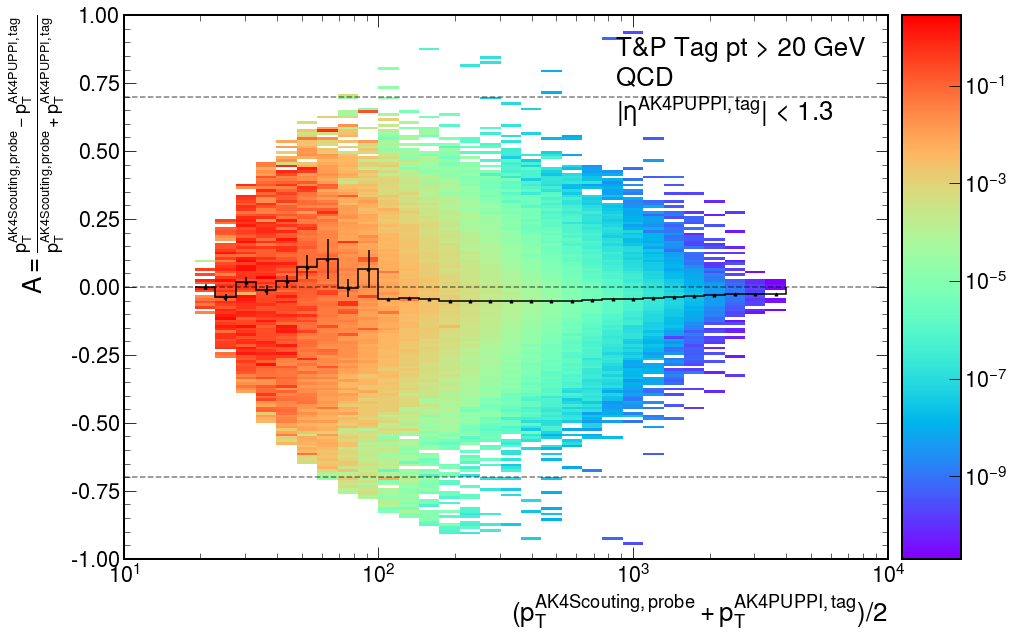

In [15]:
plot_tp_pt_balance(out, dataset="QCD", 
                 jet_type="AK4Scouting (Ave)",
                 eta_range=(0, 1.3, True), 
                 phi_range=None,
                 xlim=(10, None),
                 xscale="log", normalize_pt=False,
                 legend_title="T&P Tag pt > 20 GeV",
                 hep_args=mc_hep_args,
                 #filename="results/response_pt_corrected_notrigger_notagprobe_mc_density_xlog.png"
                )

In [ ]:
def plot_tp_mpf(out, dataset="QCD",
                     jet_type=None,
                     eta_range=None, phi_range=None, # if range None, will integrate all
                     normalize_pt=False, plot_what={"2d", "profile"},
                     fig = None, ax = None,
                     xscale=None, yscale=None, xlim=None, ylim=None,
                     legend_title=None, hep_args=None, filename=None):
    if fig == None or ax == None:
        fig, ax = plt.subplots()
    size = fig.get_size_inches()
    fig.set_size_inches((size[0]*1.5, size[1]))
    
    cmap = cm.get_cmap('rainbow')
    cmap.set_under('w')
    
    on_jet_label = out["configurations"]["Processor"]["on_jet_label"]
    off_jet_label = out["configurations"]["Processor"]["off_jet_label"]
    if not jet_type:
        jet_type = off_jet_label
        
    h = preprocess_histogram(out["tp_mpf"], dataset=dataset, \
                            jet_type=jet_type, eta_range=eta_range, phi_range=phi_range)
    
    h = (h.project("jet_pt", "tp_mpf"))[0j:, :]
    
    if plot_what == None:
        plot_what = {"2d", "profile"}
    
    if "2d" in plot_what:
        if normalize_pt:
            h_np = h.values() # convert to np
            h_np_norm = h_np / np.sum(h_np, axis=1, keepdims=True)
            h_norm = hist.Hist(*h.axes, storage=hist.storage.Double())
            h_norm.view()[:] = h_np_norm # convert back to hist
            h_norm.plot2d(ax=ax, cmap=cmap, alpha=1, norm=colors.LogNorm())

        else:
            h.plot2d(ax=ax, cmap=cmap, alpha=1, norm=colors.LogNorm())
    
    # compute profile and plot profile
    if "profile" in plot_what:
        hp = h.profile("tp_mpf")
        hp.plot(color="k", linewidth=1.5)
        ax.plot(hp.axes[0].centers, hp.to_numpy()[0], color="k", linestyle="", marker="^", markersize=3)
    
    # plot pt_response = 1.0 line
    ax.axhline(0, linestyle="dashed", color="k", alpha=0.5)
    
    ax.set_xlabel(r"$p_T^{%s}$"%off_jet_label)
    ax.set_ylabel(r"$p_T^{%s} / p_T^{%s}$"%(on_jet_label, off_jet_label))
    
    # TODO: need to move to better place...
    #off_correction_level, on_correction_level = extract_correction_level(correction_level)
    #off_jet_pt_axis_label = "\ ".join([off_jet_label, "p_T", "({})".format(off_correction_level)])
    #on_jet_pt_axis_label = "\ ".join([on_jet_label, "p_T", "({})".format(on_correction_level)])
    #if jet_type.startswith(off_jet_label):
    #    jet_type_correction_level = off_correction_level
    #else:
    #    jet_type_correction_level = on_correction_level
    #jet_type_pt_axis_label = "\ ".join([*jet_type.split("_"), "p_T", "({})".format(jet_type_correction_level)])
    #ax.set_xlabel(r"${}$".format(jet_type_pt_axis_label))
    #ax.set_ylabel(r"$R = \frac{%s}{%s}$"%(str(on_jet_pt_axis_label), str(off_jet_pt_axis_label)))
    
    ax.set_xlabel(r"$p_T^{AK4PUPPI, tag}$")
    #ax.set_xlabel(r"$(p_T^{AK4PUPPI, probe} + p_T^{AK4PUPPI, tag})/2$")
    #ax.set_xlabel(r"$(p_T^{AK4Scouting, probe} + p_T^{AK4PUPPI, tag})/2$")
    ax.set_ylabel(r"$B=\frac{\vec{p}_T^{miss} \cdot \hat{p}_T^{AK4PUPPI, tag}}{p_T^{AK4Scouting, probe} + p_T^{AK4PUPPI, tag}} $")
    #ax.set_ylabel(r"$B=\frac{\vec{p}_T^{miss} \cdot \hat{p}_T^{AK4PUPPI, tag}}{p_T^{AK4PUPPI, probe} + p_T^{AK4PUPPI, tag}} $")
    
    legend_title_list = [dataset]
    if eta_range:
        legend_title_list.append(format_eta_range_text(eta_range[0], eta_range[1], 
                                                       jet_name="AK4PUPPI, tag", omit_zero=True))
    if legend_title:
        legend_title = "\n".join([legend_title] + legend_title_list)
    else:
        legend_title = "\n".join(legend_title_list)
    
    format_plot(fig, ax, xscale=xscale, yscale=yscale, xlim=xlim, ylim=ylim,
                legend_title=legend_title, hep_args=hep_args, filename=filename)
    
    return fig, ax

In [ ]:
plot_tp_mpf(out, dataset=dataset, 
                 jet_type="AK4Scouting",
                 eta_range=(0, 1.3, True), 
                 phi_range=None,
                 xlim=(10, None),
                 xscale="log", normalize_pt=False,
                 legend_title="T&P Tag pt > 20 GeV",
                 hep_args=mc_hep_args,
                 #filename="results/response_pt_corrected_notrigger_notagprobe_mc_density_xlog.png"
                )

In [ ]:
fig, ax = plt.subplots()
pt_bin_centers = out["tp_pt_balance"].axes["jet_pt"].centers
a = out["tp_pt_balance"]["QCD", "AK4PUPPI", :, slice(-1.3j, 1.3j, sum), :].profile("tp_pt_balance")
db = (1 + a.values()) / (1 - a.values())
ax.errorbar(pt_bin_centers, db, yerr=np.sqrt(a.variances()), 
            fmt=".--", alpha=0.5, label=r"$R_{rel}^{p_T} = \frac{1+\langle A \rangle}{1 - \langle A \rangle}$")
b = out["tp_mpf"]["QCD", "AK4PUPPI", :, slice(-1.3j, 1.3j, sum), :].profile("tp_mpf")
mpf = (1 + b.values()) / (1 - b.values())
ax.errorbar(pt_bin_centers, mpf, yerr=np.sqrt(b.variances()), 
            fmt=".--", alpha=0.5, label=r"$R_{rel}^{MPF} = \frac{1+\langle B \rangle}{1 - \langle B \rangle}$")
pf1 = out["tp_response"]["QCD", "AK4PUPPI", :, slice(-1.3j, 1.3j, sum), :].profile("tp_response")
ax.errorbar(pt_bin_centers, pf1.values(), yerr=np.sqrt(pf1.variances()), 
            fmt=".--", alpha=0.5, label=r"$\langle\frac{p_T^{AK4PUPPI, probe}}{p_T^{AK4PUPPI, tag}}\rangle$")
ax.axhline(1, linestyle="dashed", color="k", alpha=0.5)
ax.set_xlabel(r"$p_T^{AK4PUPPI, tag}$")
ax.set_ylabel(r"Response")
format_plot(fig, ax, xscale="log", yscale="linear", xlim=(10, None), ylim=None,
            legend_title="T&P Tag pt > 20 GeV\nQCD\n$|\eta^{AK4PUPPI, tag}|$", hep_args=mc_hep_args, filename=None)

In [ ]:
fig, ax = plt.subplots()
jet_type = "AK4Scouting"
pt_bin_centers = out["tp_pt_balance"].axes["jet_pt"].centers
a = out["tp_pt_balance"]["QCD", jet_type, :, slice(-1.3j, 1.3j, sum), :].profile("tp_pt_balance")
db = (1 + a.values()) / (1 - a.values())
ax.errorbar(pt_bin_centers, db, yerr=np.sqrt(a.variances()), 
            fmt=".--", alpha=0.5, label=r"$R_{rel}^{p_T} = \frac{1+\langle A \rangle}{1 - \langle A \rangle}$")
b = out["tp_mpf"]["QCD", jet_type, :, slice(-1.3j, 1.3j, sum), :].profile("tp_mpf")
mpf = (1 - b.values()) / (1 + b.values())
ax.errorbar(pt_bin_centers, mpf, yerr=np.sqrt(b.variances()), 
            fmt=".--", alpha=0.5, label=r"$R_{rel}^{MPF} = \frac{1+\langle B \rangle}{1 - \langle B \rangle}$")
pf2 = out["tp_response"]["QCD", jet_type, :, slice(-1.3j, 1.3j, sum), :].profile("tp_response")
ax.errorbar(pt_bin_centers, pf2.values(), yerr=np.sqrt(pf2.variances()), 
            fmt=".--", alpha=0.5, label=r"$\langle\frac{p_T^{AK4Scouting, probe}}{p_T^{AK4PUPPI, tag}}\rangle$")
pf_ratio = pf2.values()/pf1.values()
pf_ratio_std = pf_ratio * np.sqrt(pf1.variances()/pf1.values()**2 + pf2.variances()/pf2.values()**2)
ax.errorbar(pt_bin_centers, pf_ratio, yerr=pf_ratio_std, 
            fmt=".--", alpha=0.5, label=r"$\langle\frac{p_T^{AK4Scouting, probe}}{p_T^{AK4PUPPI, tag}}\rangle$")
ax.axhline(1, linestyle="dashed", color="k", alpha=0.5)
ax.set_xlabel(r"$p_T^{AK4PUPPI, tag}$")
ax.set_ylabel(r"Response")
format_plot(fig, ax, xscale="log", yscale="linear", xlim=(10, None), ylim=None,
            legend_title="T&P Tag pt > 20 GeV\nQCD\n$|\eta^{AK4PUPPI, tag}|$", hep_args=mc_hep_args, filename=None)